# Dwave dataset
- Training RBM to learn distribution of Dwave output

# Tasks
1. Generate 10000 samples
2. Ensure the samples are generated from an equilibrated model. What metric do you use to prove equilibrium?
3. Report the mean of each Ising variable
4. Report the mean correlation of pairs of variables listed

#### Training
- We first train RBM using PCD and track likelihood of training data to see if it converges.
- Visible node count = 2041 is quite a high demand. With time limited for the cohort, the training is incomplete.
 - I could not use sufficient node count ~O(visible) for hidden nodes.
 - I could not use sufficient CD-k steps ~O(visible).
 - I could not do sufficient epochs.

- Convergence, i.e. equilibrium, are tracked while training using log-likelihood .

In [ ]:
from datetime import datetime
import pandas as pd
import torch
from helper import load_dataset
train_data, test_data = load_dataset('dataset_x1a46w3557od23s750k9.npz')
df = pd.read_csv('correlated_features.csv')

from RBM_helper import RBM

total_data_count, visible_nodes = train_data.shape


n_vis = visible_nodes
n_hin = int(n_vis / 10)
rbm = RBM(n_vis, n_hin)

train_data = torch.Tensor(train_data)

def train(rbm):
    epochs = 100
    # num_samples = visible_nodes * 10
    k_train = 100
    k_validate = n_vis + n_hin
    print('Starting training on n_h = ', n_hin)
    energies = []
    for e in range(1, epochs+1):
        # do one epoch of training
        start = datetime.now()
        rbm.train(train_data, k=k_train)
        end = datetime.now()
        print(f"Elapsed {end - start} for epoch {e}")
        # now generate samples and calculate the energy
        if e % 10 == 0:
            print("\nEpoch: ", e)
            # We check if log likelihood of training data converges
            energy = rbm.effective_energy(train_data).item()
            energies.append(energy)
            print("Energy : ", energy)
    return energies

In [ ]:
likelihooods = train(rbm)
rbm.save_params('dwave_k100_e400')
df = pd.DataFrame(likelihoods)
df.to_csv('dwave_k100_e400_ll.csv')

## 1 Drawing samples
- Drawing from random state

In [1]:
import torch
from RBM_helper import RBM
from datetime import datetime
rbm = RBM.from_weights('params/dwave_k100_e400')
n_vis = rbm.n_vis
sample_count = 10000
k = 1000
initial_state = torch.rand((sample_count, n_vis)).cuda()
rbm = rbm.to(initial_state)
start = datetime.now()
samples = rbm.draw_samples(k, initial_state)
end = datetime.now()
print(f"Elapsed {end - start} for k = {k}")

rbm2 = RBM.from_weights('params/dwave_k100_e401-1000')
rbm2 = rbm2.to(initial_state)
start = datetime.now()
samples2 = rbm.draw_samples(k, initial_state)
end = datetime.now()
print(f"Elapsed {end - start} for k = {k}")

Elapsed 0:00:10.529769 for k = 1000
Elapsed 0:00:10.407516 for k = 1000


## 2 Check if training is converged
- By viewing log likelihood tracking, it seems the training is still ongoing.
- However for rough qualitative point of view, it seems almost sufficient as shown in the following sections.

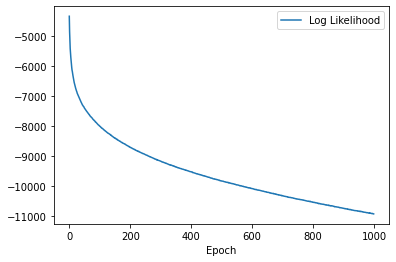

In [1]:
import pandas as pd
ll_df1 = pd.read_csv('training_logs/dwave_k100_e400_ll.csv', names=['Log Likelihood'], skiprows=1)
ll_df2 = pd.read_csv('training_logs/dwave_k100_e401-1000_ll.csv', names=['Log Likelihood'], skiprows=1)
ll_df2.index = list(range(400, 1000))
ll_df = pd.concat([ll_df1, ll_df2])
ll_df.index.name = 'Epoch'
ll_df.plot()

## 2 Calculating mean of each spins
- While the log likelihood is still decreasing, another 600 epochs after 400 epochs does not change mean spin population.
- It shows it almost reached the equilibrium state.

Text(0.5, 0, 'Spin mean')

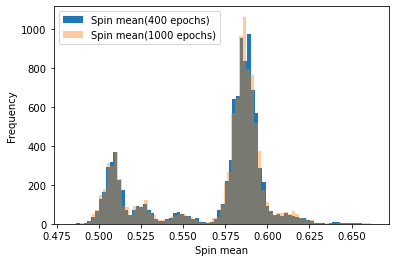

In [12]:
import pandas as pd
samples_numpy = samples.cpu().numpy()
average = samples_numpy.mean(axis=1)

samples_numpy2 = samples2.cpu().numpy()
average2 = samples_numpy2.mean(axis=1)

df = pd.DataFrame(average, columns=['Spin mean(400 epochs)'])
ax = df.plot.hist(bins=80)
df2 = pd.DataFrame(average2, columns=['Spin mean(1000 epochs)'])
df2.plot.hist(bins=80, ax=ax, alpha=0.4)
ax.set_xlabel('Spin mean')



## 3 Calculate correlation between each pairs specified
- Spin correlations are also does not significantly changes if we train more.

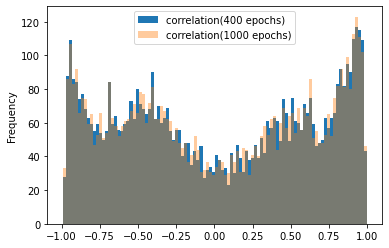

In [10]:
correlated_df = pd.read_csv('correlated_features.csv', index_col=0)
correlated_df
samples_df = pd.DataFrame(samples_numpy)


correlations = pd.DataFrame(columns=['correlation(400 epochs)'])
for i in correlated_df.index:
    correlations.loc[i] = samples_df[correlated_df['left'][i]].corr(samples_df[correlated_df['right'][i]])



samples_df2 = pd.DataFrame(samples_numpy2)


correlations2 = pd.DataFrame(columns=['correlation(1000 epochs)'])
for i in correlated_df.index:
    correlations2.loc[i] = samples_df2[correlated_df['left'][i]].corr(samples_df2[correlated_df['right'][i]])

ax = correlations.plot.hist(bins=100)
correlations2.plot.hist(bins=100, ax=ax, alpha=0.4)

    

In [13]:
correlations.to_csv('correlations_e400.csv')
correlations2.to_csv('correlations_e401-100.csv')